In [ ]:
pip install pandas

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
import warnings

In [ ]:
# import data, choose columns to use
data = pd.read_csv("https://drive.google.com/uc?id=1oQBS1T4TiAfikl0GHXhXb22ASaWZEj2S")
columns = ["track_name", "popularity", "danceability", "energy", "speechiness", "acousticness", "instrumentalness", "valence", "tempo", "track_genre"]
data1 = data[columns]

# change track_genre to numerical values
data_1a = data1.copy()
data_1a["track_name"] = data_1a["track_name"].astype('category')
data_1a["track_genre"] = data_1a["track_genre"].astype('category')
cat_columns = data_1a.select_dtypes(['category']).columns
data_1a[cat_columns] = data_1a[cat_columns].apply(lambda x: x.cat.codes)

# choose columns we want to use
columns_1a = ["track_name", "popularity", "danceability", "energy", "speechiness", "acousticness", "instrumentalness", "valence", "tempo", "track_genre"]
data_1b = data_1a[columns_1a]

print(data_1b)

# normalize data using min-max scaling
scaler = MinMaxScaler()
data_1c = scaler.fit_transform(data_1b)
data_1c = pd.DataFrame(data_1c, columns=data_1b.columns)
data_1c["name"] = data1["track_name"]

# sort data by popularity in each genre, choose top 50 of each genre
data_1d = data_1c.groupby("track_genre", group_keys=False).apply(lambda group: group.nlargest(50, "popularity"))

# zip x columns into one X
X = data_1d[["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "valence", "tempo", "track_genre"]]
Y = data_1d["track_name"]

# keep song names in separate array
song_names = data_1d["name"]
song_dict = {i: song for i, song in enumerate(song_names)}

# make copies of X and Y
X_copy = X.copy()
Y_copy = Y.copy()
print(X_copy)

        track_name  popularity  danceability  energy  speechiness  \
0            11741          73         0.676  0.4610       0.1430   
1            22528          55         0.420  0.1660       0.0763   
2            60774          57         0.438  0.3590       0.0557   
3             9580          71         0.266  0.0596       0.0363   
4            25689          82         0.618  0.4430       0.0526   
...            ...         ...           ...     ...          ...   
113995       53329          21         0.172  0.2350       0.0422   
113996       65090          22         0.174  0.1170       0.0401   
113997       38207          22         0.629  0.3290       0.0420   
113998       21507          41         0.587  0.5060       0.0297   
113999        5999          22         0.526  0.4870       0.0725   

        acousticness  instrumentalness  valence    tempo  track_genre  
0             0.0322          0.000001   0.7150   87.917            0  
1             0.9240       

<ipython-input-4-64d53cf6ff79>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_1d = data_1c.groupby("track_genre", group_keys=False).apply(lambda group: group.nlargest(50, "popularity"))


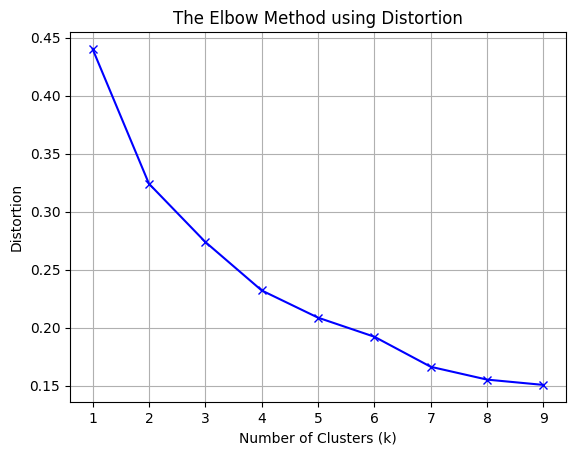

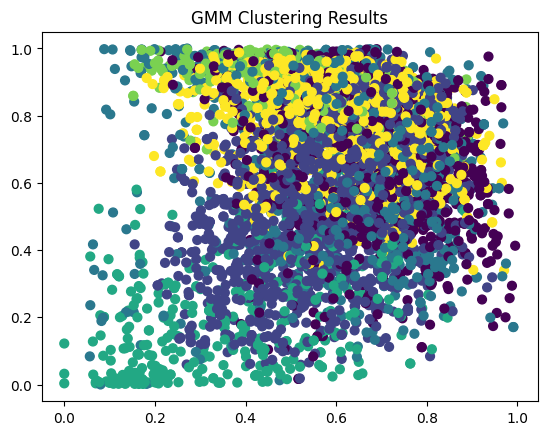

In [ ]:
# Fit K-means for different values of k
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

# test different number of clusters
for k in K:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(X_copy)
  distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)**2) / X_copy.shape[0])
  inertias.append(kmeans.inertia_)
  mapping1[k] = distortions[-1]
  mapping2[k] = inertias[-1]
  preds = kmeans.fit_predict(X_copy)

# plot elbow curve
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.grid()
plt.show()

# Create a GMM model with 6 components
gmm = GaussianMixture(n_components=6, random_state=0)

# Fit the GMM to the data
gmm.fit(X_copy)

# Get cluster probabilities
probabilities = gmm.predict_proba(X_copy)

# Predict the cluster labels for each data point
labels = gmm.predict(X_copy)

# Extract Data for Specific Clusters
cluster_data = [X_copy[labels == i] for i in range(gmm.n_components)]

# Plot the data and cluster labels
plt.scatter(X_copy.iloc[:, 0], X_copy.iloc[:, 1], c=labels, s=40)
plt.title('GMM Clustering Results')
plt.show()

In [ ]:
# check that GMM can find closest songs to the data point in the cluster with an existing song

# TEST "CAN'T HELP FALLING IN LOVE"
song_name = "Can't Help Falling In Love"

# song we want to find
song_index = [i for i, song in song_dict.items() if song == song_name]

# Retrieve the data point (features) from X based on the index
data_point = X_copy.iloc[song_index[0]]

# Predict the cluster assignment for each data point
labels = gmm.predict(X)

# Find the cluster to which the song belongs
cluster_idx = gmm.predict([data_point])[0]

# Filter data points that belong to the same cluster
cluster_points = X[labels == cluster_idx]

# Compute the pairwise distances between the data point and the points in the same cluster
distances = pairwise_distances([data_point], cluster_points)

# Sort by distance and get the 10 closest points
sorted_indices = np.argsort(distances[0])
closest_songs = [song_dict[idx] for idx in sorted_indices[:10]]
print("The closest songs to \"", song_name, "\" are:", closest_songs)

# TEST "SAY SOMETHING"
song_name = "Say Something"

# song we want to find
song_index = [i for i, song in song_dict.items() if song == song_name]

# Retrieve the data point (features) from X based on the index
data_point = X_copy.iloc[song_index[0]]

# Predict the cluster assignment for each data point
labels = gmm.predict(X)

# Find the cluster to which the song belongs
cluster_idx = gmm.predict([data_point])[0]

# Filter data points that belong to the same cluster
cluster_points = X[labels == cluster_idx]

# Compute the pairwise distances between the data point and the points in the same cluster
distances = pairwise_distances([data_point], cluster_points)

# Sort by distance and get the 10 closest points
sorted_indices = np.argsort(distances[0])
closest_songs = [song_dict[idx] for idx in sorted_indices[:10]]
print("The closest songs to \"", song_name, "\" are:", closest_songs)

The closest songs to " Can't Help Falling In Love " are: ['Suddenly I See', 'Cry', 'Lucky', 'Asan Ka Na Ba', 'Pano', 'Cliffs Of Dover - Instrumental', 'Settled Down', 'saman', 'The Outsider', 'Groovy Flute']
The closest songs to " Say Something " are: ['Pano', 'Asan Ka Na Ba', 'Groovy Flute', 'The Outsider', 'Cry', 'Falling In Love', 'Take Me Out', 'Spies Are Watching Me', 'Walking On A Dream', 'Blister In The Sun']


In [ ]:
# function to create fake songs
def make_song():
  default = {
      "danceability": 0.0,
      "energy": 0.0,
      "speechiness": 0.0,
      "acousticness": 0.0,
      "instrumentalness": 0.0,
      "valence": 0.0,
      "tempo": 0.0,
      "track_genre": 0.0
  }
  test_df = pd.DataFrame([default])

  # randomize from 0 - 1 all columns except for track_genre
  columns_to_update = ["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "valence", "tempo"]
  test_df[columns_to_update] = np.random.rand(test_df.shape[0], len(columns_to_update))

  # randomize track_genre given a list
  track_genres = [
      0.0, 0.00884956, 0.01769912, 0.02654867, 0.03539823, 0.04424779, 0.05309735, \
      0.0619469, 0.07079646, 0.07964602, 0.08849558, 0.09734513, \
      0.10619469, 0.11504425, 0.12389381, 0.13274336, 0.14159292, 0.15044248,\
      0.15929204, 0.16814159, 0.17699115, 0.18584071, 0.19469027, 0.20353982,\
      0.21238938, 0.22123894, 0.2300885, 0.23893805, 0.24778761, 0.25663717,\
      0.26548673, 0.27433628, 0.28318584, 0.2920354, 0.30088496, 0.30973451,\
      0.31858407, 0.32743363, 0.33628319, 0.34513274, 0.3539823, 0.36283186,\
      0.37168142, 0.38053097, 0.38938053, 0.39823009, 0.40707965, 0.4159292,\
      0.42477876, 0.43362832, 0.44247788, 0.45132743, 0.46017699, 0.46902655,\
      0.47787611, 0.48672566, 0.49557522, 0.50442478, 0.51327434, 0.52212389,\
      0.53097345, 0.53982301, 0.54867257, 0.55752212, 0.56637168, 0.57522124,\
      0.5840708, 0.59292035, 0.60176991, 0.61061947, 0.61946903, 0.62831858,\
      0.63716814, 0.6460177, 0.65486726, 0.66371681, 0.67256637, 0.68141593,\
      0.69026549, 0.69911504, 0.7079646, 0.71681416, 0.72566372, 0.73451327,\
      0.74336283, 0.75221239, 0.76106195, 0.7699115, 0.77876106, 0.78761062,\
      0.79646018, 0.80530973, 0.81415929, 0.82300885, 0.83185841, 0.84070796,\
      0.84955752, 0.85840708, 0.86725664, 0.87610619, 0.88495575, 0.89380531,\
      0.90265487, 0.91150442, 0.92035398, 0.92920354, 0.9380531, 0.94690265,\
      0.95575221, 0.96460177, 0.97345133, 0.98230088, 0.99115044, 1.0,\
      0.67256637
  ]
  test_df["track_genre"] = np.random.choice(track_genres, size=test_df.shape[0])

  print("Features of new song: ")
  print(test_df)
  return test_df.iloc[0]

Features of new song: 
   danceability    energy  speechiness  acousticness  instrumentalness  \
0      0.012014  0.338968     0.594097      0.112884          0.461656   

    valence     tempo  track_genre  
0  0.118607  0.671913      0.19469  


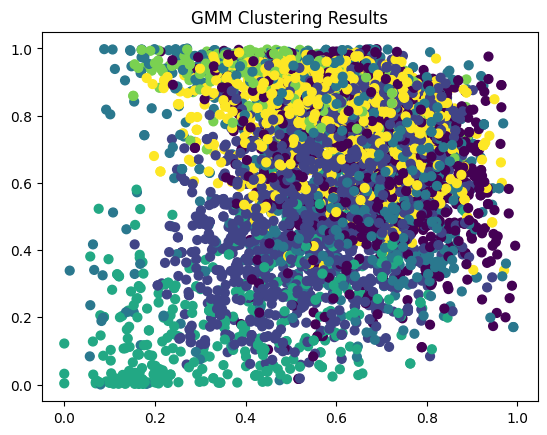

The closest songs to " New Song " are: ['污糟兒', 'Conquer All', '如愿', 'Settled Down', 'Pump Action', 'Caroline', 'Portland, Maine', '單車', 'Already Gone', 'Softcore']


In [ ]:
# RERUN THIS CODE BLOCK TO MAKE NEW SONGS AND TEST IN GMM

# make a new dataframe and add new song
X_copy = X.copy()
X_copy.loc[5700] = make_song()

# add song name to song_dict
song_dict[5700] = "New Song"

# Create a GMM model with 6 components
gmm = GaussianMixture(n_components=6, random_state=0)

# Fit the GMM to the data
gmm.fit(X_copy)

# Get cluster probabilities
probabilities = gmm.predict_proba(X_copy)

# Predict the cluster labels for each data point
labels = gmm.predict(X_copy)

# Extract Data for Specific Clusters
cluster_data = [X_copy[labels == i] for i in range(gmm.n_components)]

# Plot the data and the predicted cluster labels
plt.scatter(X_copy.iloc[:, 0], X_copy.iloc[:, 1], c=labels, s=40)
plt.title('GMM Clustering Results')
plt.show()

# TEST NEW SONG
song_name = "New Song"

# song we want to find
song_index = [i for i, song in song_dict.items() if song == song_name]

# Retrieve the data point (features) from X based on the index
data_point = X_copy.iloc[song_index[0]]

# Predict the cluster assignment for each data point
labels = gmm.predict(X)

# Find the cluster to which the `data_point` belongs
cluster_idx = gmm.predict([data_point])[0]

# Filter data points that belong to the same cluster
cluster_points = X[labels == cluster_idx]

# Compute the pairwise distances between the data point and the points in the same cluster
distances = pairwise_distances([data_point], cluster_points)  # Keep data_point as 2D

# Sort by distance and get the 10 closest points (or fewer if there are fewer points)
sorted_indices = np.argsort(distances[0])
closest_songs = [song_dict[idx] for idx in sorted_indices[:10]]
print("The closest songs to \"", song_name, "\" are:", closest_songs)

In [ ]:
z=set('abcde')
y=set('ab')
print('a' in z-y)

False


In [ ]:
f = None
for i in range(10):
    with open("test.txt", "w") as f:
        if i > 5:
            break
print(f.closed)

True
